Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn.datasets import load_digits

In [8]:
X, y = load_digits(return_X_y=True)

In [9]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

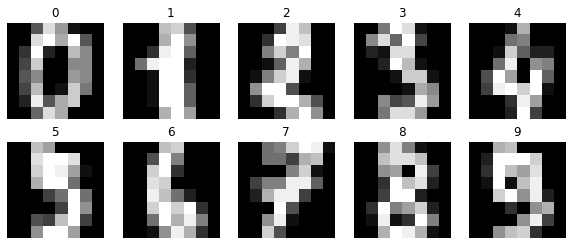

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for ax, image, label in zip(axes.flatten(), X[:10], y[:10]):
    ax.set_axis_off()
    ax.set_title(label)
    ax.imshow(image.reshape((8, 8)), cmap='gray')

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [40]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [424]:
from sklearn.metrics import pairwise_distances

In [831]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=30
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        return np.sqrt(np.sum((X[:,None]-cluster_centers)**2, -1))
        
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        d = self.calculate_distances_to_centroids(X, nearest_clusters)
        labels = np.argmin(d, 1)
        return np.array([np.mean(X[labels==l], 0) for l in range(self.n_clusters)])
        

    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
#         loss = np.zeros(self.n_init)
        self.loss_ = np.full(self.n_init, np.inf)
        cluster_runs = []
        for run in range(self.n_init):
            # выбираем просто случайные центры
#             self.cluster_centers_ = self.random_state.random((self.n_clusters, X.shape[1]))
            # выбираем центры из имеющихся точек
            self.cluster_centers_ = X[self.random_state.choice(range(X.shape[0]), self.n_clusters, replace=0)] 
            for i in range(self.max_iter):
                d = self.calculate_distances_to_centroids(X, self.cluster_centers_)
                # наздначаем точкам класcы
                labels = np.argmin(d, 1)
                # бывает такое, что какой-то из центров кластеров далеко и к нему никто не хочет идти
                # поэтому идем генерироватьь новые центры
                if len(np.unique(labels)) < self.n_clusters:
                    break
                # усредняем точки внутри кластеров, обновляем центры кластеров
                self.cluster_centers_ = np.array([np.mean(X[labels==l], 0) for l in range(self.n_clusters)])
                # loss для KMeans
                l = np.sum((X - self.cluster_centers_[labels])**2)
                # если попали в минимум прерываемся и идем пробовать новые центры
                if abs(l - self.loss_[run]) < 1e-5:
                    break
                self.loss_[run] = l
#                 self.cluster_centers_ = self.update_centroids(X, self.cluster_centers_)
#             d = self.calculate_distances_to_centroids(X, self.cluster_centers_)
#             labels = np.argmin(d, 1)
            cluster_runs.append(self.cluster_centers_)
        # по результатам лосса за все n_init выбираем лучшие центры кластеров
        self.cluster_centers_ = cluster_runs[np.argmin(self.loss_)]
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            d = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return np.argmin(d, 1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [832]:
km = CustomKMeans(n_clusters=10,random_state=42)

In [833]:
km.fit(X)

Так как центры кластеров выбираются как среднее среди всех точек принадлежащих кластеру, то достаточно просто отобразить центры кластеров, полученные во время обучения (хранятся внутри `cluster_centers_`)

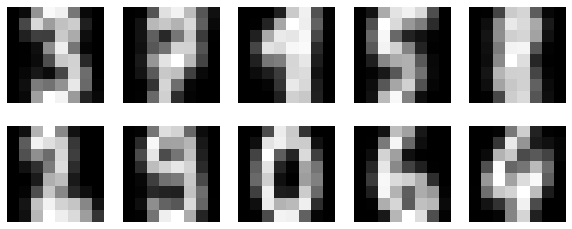

In [834]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for ax, image in zip(axes.flatten(), km.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap='gray')

In [835]:
custom_kmeans_labels = km.predict(X)
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [572]:
loss = []
for max_iter in range(1,50,5):
    km = CustomKMeans(n_clusters=10, max_iter=max_iter, n_init=10)
    km.fit(X)
    loss.append(km.loss_)

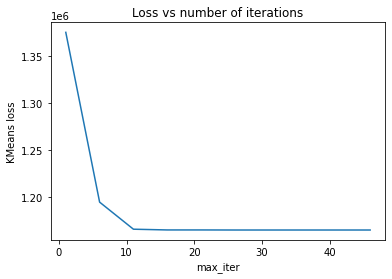

In [579]:
plt.plot(np.arange(1,50,5), np.amin(loss,1))
plt.title('Loss vs number of iterations');
plt.xlabel('max_iter');
plt.ylabel('KMeans loss');

Мы зафиксировали один из параметров(`n_init`), чтобы посмотреть как меняется loss в зависимости от количества итераций (`max_iter`). По графику хорошо виден "локоть", по которому можно выбратьь оптимальное значение параметра `max_iter`(11).
Зафиксируем это значение и будем менять уже `n_init`

In [582]:
loss = []
for n_init in range(1,50,5):
    km = CustomKMeans(n_clusters=10, max_iter=11, n_init=n_init)
    km.fit(X)
    loss.append(km.loss_)

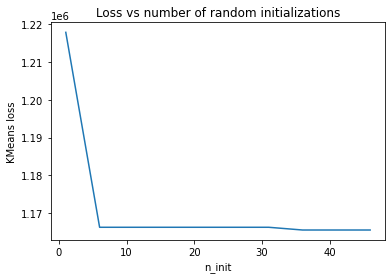

In [589]:
plt.plot(np.arange(1,50,5), [np.min(l) for l in loss])
plt.title('Loss vs number of random initializations');
plt.xlabel('n_init');
plt.ylabel('KMeans loss');

Наблюдаем такую же картину, отчетливо виден "локоть", с оптимальным значением параметра `n_init`, после которого значение лосса меняется незначительно

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [590]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [614]:
skl_km =  KMeans(n_clusters=10,n_init=20).fit(X)

In [620]:
skl_hier = AgglomerativeClustering(n_clusters=10).fit(X)

In [621]:
hierarchical_labels = skl_hier.labels_
kmeans_labels = skl_km.predict(X)

In [622]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

Центры кластеров полученные с помощью KMeans

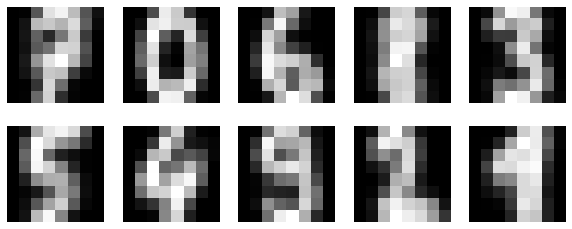

In [623]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for ax, image in zip(axes.flatten(), skl_km.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap='gray')

Центры кластеров полученные с помощью Hierarchical Clustering

Этот метод не возвращает центры кластеров(потому что и не ищет их), поэтому просто усредним точки с одинаковыми значениями найденных классов

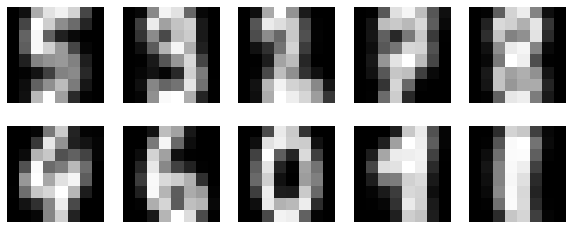

In [626]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for ax, image in zip(axes.flatten(), np.array([np.mean(X[hierarchical_labels==l], 0) for l in range(10)])):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap='gray')

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [734]:
from sklearn.metrics import silhouette_samples, silhouette_score, v_measure_score

Попробую вычислить силуэт точки сам без библиотечной функции:<br>
(посчитаем количество точек внутри кластеров — число одинаковых лэйблов кластера, параметр $M$ в выражении для $a(x)$)

In [644]:
l, fr = np.unique(skl_km.labels_,return_counts=1)

Посчитаем среднее внутрикластерное расстояние для точки X[0]
(в определении силуэта это $a(x)$)

In [677]:
a = np.sum(np.sqrt(np.sum((X[0]-X[skl_km.labels_==skl_km.labels_[0]])**2,-1)))/(fr[skl_km.labels_[0]]-1)
a

23.898804294820867

Посчитаем средние расстояния от точки X[0] до точек в других кластерах и найдем минимальное среди таких

In [680]:
b = np.min([np.mean(np.sqrt(np.sum((X[0]-X[skl_km.labels_==i])**2,-1))) for i in range(10) if i!=1])
b

41.40037780778469

посчитаем силуэт точки X[0]

In [682]:
(b-a)/max(a,b)

0.4227394637368002

Сравним со значением для точки X[0] библиотечной фукнции:

In [683]:
silhouette_samples(X,skl_km.labels_)[0]

0.4227394637368006

Получили одинаковое значение<br> 
Можно дальше это сделать для всех точек датасета и усреднить, но моя реализация очень неоптимальна, так что воспользуюсь библиотечной функцией

In [711]:
sil_km = []
sil_hier = []
for k in range(2,21):
    km_sil = KMeans(n_clusters=k, max_iter=30)
    hier_sil = AgglomerativeClustering(n_clusters=k)
    km_sil.fit(X)
    hier_sil.fit(X)
    sil_km.append(silhouette_score(X, km_sil.labels_))
    sil_hier.append(silhouette_score(X, hier_sil.labels_))

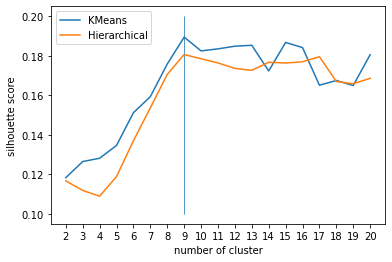

In [746]:
plt.plot(np.arange(2,21), sil_km, label='KMeans');
plt.plot(np.arange(2,21), sil_hier, label='Hierarchical');
plt.vlines(np.argmax([sil_hier,sil_km],1)+2, 0.1, 0.2, linewidth=0.5);
plt.xticks(np.arange(2,21));
plt.xlabel('number of cluster');
plt.ylabel('silhouette score');
plt.legend();

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [736]:
v_score_km = []
v_score_hier = []
for k in range(2,21):
    km_v_sc = KMeans(n_clusters=k, max_iter=30)
    hier_v_sc = AgglomerativeClustering(n_clusters=k)
    km_v_sc.fit(X)
    hier_v_sc.fit(X)
    v_score_km.append(v_measure_score(y, km_v_sc.labels_))
    v_score_hier.append(v_measure_score(y, hier_v_sc.labels_))

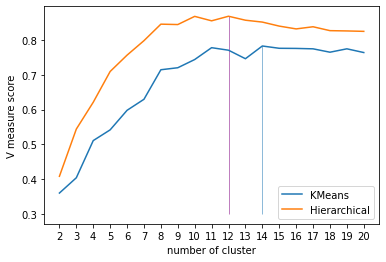

In [752]:
plt.plot(np.arange(2,21), v_score_km, label='KMeans');
plt.plot(np.arange(2,21), v_score_hier, label='Hierarchical');
plt.vlines(np.argmax(v_score_km)+2, 0.3, max(v_score_km), linewidth=0.5);
plt.vlines(np.argmax(v_score_hier)+2, 0.3, max(v_score_hier), linewidth=0.5,colors='purple');
plt.xticks(np.arange(2,21))
plt.xlabel('number of cluster');
plt.ylabel('V measure score');
plt.legend();

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [781]:
from sklearn.decomposition import TruncatedSVD

Посчитаем силуэт и v-score для полных данных в качестве бэйзлайна:

In [782]:
km = KMeans(n_clusters=10).fit_predict(X)
hier = AgglomerativeClustering(n_clusters=10).fit_predict(X)

In [791]:
print(f"kmeans c полными данными, 10 кластеров\nсилуэт={silhouette_score(X,km)}, v_score={v_measure_score(y, km)}")
print(f"hierarchical c полными данными, 10 кластеров\nсилуэт={silhouette_score(X,hier)}, v_score={v_measure_score(y, hier)}")

kmeans c полными данными, 10 кластеров
силуэт=0.18211115081307583, v_score=0.7373557208714144
hierarchical c полными данными, 10 кластеров
силуэт=0.17849659940596496, v_score=0.8681701126909083


In [794]:
for feat in [2,5,10,20]:
    reduced_X = TruncatedSVD(feat).fit_transform(X)
    km = KMeans(n_clusters=10).fit_predict(reduced_X)
    hier = AgglomerativeClustering(n_clusters=10).fit_predict(reduced_X)
    print(f'kmeans {feat} features, silh={silhouette_score(X,km)}, v_score={v_measure_score(y, km)}')
    print(f'hierarchical {feat} features, silh={silhouette_score(X,hier)}, v_score={v_measure_score(y, hier)}',end='\n\n')

kmeans 2 features, silh=0.00634464991465075, v_score=0.34651180104021345
hierarchical 2 features, silh=-0.007681018630218928, v_score=0.3337189903948925

kmeans 5 features, silh=0.16859796560589405, v_score=0.6351431850310999
hierarchical 5 features, silh=0.1620113963829507, v_score=0.6756036446423491

kmeans 10 features, silh=0.18051375012934556, v_score=0.721854504251811
hierarchical 10 features, silh=0.1765881132796084, v_score=0.8259753348813222

kmeans 20 features, silh=0.18222098898513137, v_score=0.7417709309180348
hierarchical 20 features, silh=0.16913283397404957, v_score=0.8143882689038883



Видно, что для hierarchical clustering с точки зрения значения обеих метрик, 10 признаков полученных после SVD-разложения является оптимальным, значения получились очень близкими к полученным на исходных данных, при этом вычислительно 10 признаков по сравнению с 64 — дают значительный прирост<br>
Для k-means 20 признаков оказалось оптимальным, v-score получился даже выше, что опять же уменьшает вычислительную сложность по сравнению с 64 признаками.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

In [755]:
from sklearn.manifold import TSNE

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [807]:
tsne_x = TSNE().fit_transform(X)

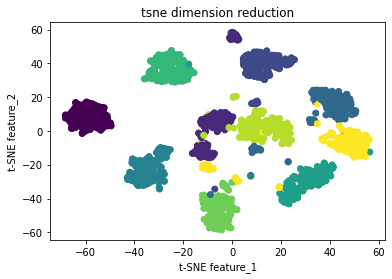

In [808]:
plt.scatter(tsne_x[:,0], tsne_x[:,1], c=y);
plt.title('tsne dimension reduction')
plt.xlabel('t-SNE feature_1');
plt.ylabel('t-SNE feature_2');

Так как tsne старается сохранить внутрикластерные расстояния при уменьшении размерности, видно, что кластеры соответствующие однаковым цифрам оказались сгруппированы вместе.

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [795]:
km_tsne = KMeans(n_clusters=10).fit_predict(tsne_x)
hier_tsne = AgglomerativeClustering(n_clusters=10).fit_predict(tsne_x)

In [798]:
print(f"kmeans c полными данными, 10 кластеров\nсилуэт={silhouette_score(X,km)}, v_score={v_measure_score(y, km)}")
print(f"hierarchical c полными данными, 10 кластеров\nсилуэт={silhouette_score(X,hier)}, v_score={v_measure_score(y, hier)}")

kmeans c полными данными, 10 кластеров
силуэт=0.18222098898513137, v_score=0.7417709309180348
hierarchical c полными данными, 10 кластеров
силуэт=0.16913283397404957, v_score=0.8143882689038883


In [803]:
print('метрики после понижения размерности tsne для kmeans(силуэт,v-score соотвественно)\n',silhouette_score(X, km_tsne), v_measure_score(y, km_tsne))
print('метрики после понижения размерности tsne для hiearchical clustering (силуэт,v-score соотвественно)\n',silhouette_score(X, hier_tsne), v_measure_score(y, hier_tsne))

метрики после понижения размерности tsne для kmeans(силуэт,v-score соотвественно)
 0.16417954382015898 0.9031527387720559
метрики после понижения размерности tsne для hiearchical clustering (силуэт,v-score соотвественно)
 0.16395023788428867 0.9087452370642025


#### Ввиду того, что tsne сбивает точки в плотные сферические кластеры, алгоритмы kmeans и hierarchical clustering показывают очень высокие v-score, для hierarchical значение силуэта также очень близко к оригинальным данным

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

Выберу разбиение, которое дает hierarchical clustering после понижения размерности, потому что высокий v-score(выше чем у kmeans) и значение силуэта высокое и почти как на исходных данных

In [826]:
hier_tsne.shape

(1797,)

In [827]:
np.unique(hier_tsne)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

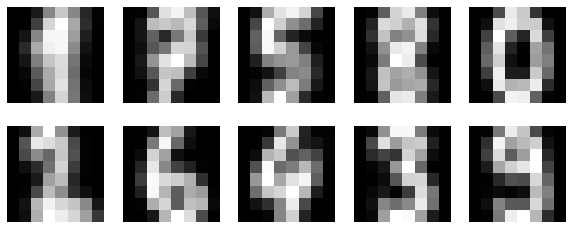

In [830]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for ax, image in zip(axes.flatten(), np.array([np.mean(X[hier_tsne==l],0) for l in range(10)])):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap='gray')

Центры кластеров получились хорошо различими, по сравнению с предыдущими вариантами цифры стали более четкие, что говорит о том, что близкие по написанию цифры были более хорошо сгруппированы(лучше стали различимы цифры 8, 4, 5, 9)

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Я не могу сказать, что какой-то из двух алгоримов давал значительно лучшие результаты. K-means зависит от случайного выбора начальных позиций центров и может попасть в локальный минимум. Иерархическое разбиение, полагаясь на расстояния, постепенно собирает точки во все более крупные кластеры(или наоборот рекурсивно разбивает большой кластер, пока не поулчатся искомые н-кластеров). Оба метода стали показывать лучшие результаты после того как TSNE собрал точки в сферические кластеры<br>
Для kmeans важно сделать несколько итераций с разными стартовыми позициями, так как количестов итераций за которое он сходится к стабильным центрам обычно небольшое(перестает меняться положение центров и лосс соответственно) так можно с большей вероятностью попасть ближе к глобальному оптимуму. 

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Для новых точек посчитать попарные расстояния (использовать ту же метрику, что была использована при обучении), использовать для этих точек классы полученных ближайших соседей.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Я уже писал выше об этом, но да, для некоторых типов кластеризации методы понижения размерности(и PCA и tsne) улучшают качество кластеризации, так как либо сохраняют расстояния при переходе в пространство меньшей размерности, либо максимизиуруют дисперсию данных при уменьшении размерности

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

Мы можем получить лейблы на исходных данных, понизить размерность, получитьь лейблы классов на новых данных, затем использовать 
V-score(1) или Rand Index(2) для сравнения двух наборов лейблов.
Так же мы можем посчитать силуэт для разбиения исходных данных, силуэт разбиения для данных пониженной размерности(относительно исходных данных) и сравнить полученные значения.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.